Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import keras.backend as kb
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, make_scorer
# %matplotlib inline


Using TensorFlow backend.


Import Data

In [2]:
df = pd.read_csv("glass_data.csv")

In [3]:
# define X and y
X = df.iloc[:,1:-1]
y = df['Tg'] # glass transition temperature

In [4]:
X.head()

,Li,Be,B,O,Na,Mg,Al,Si,P,K,...,Lu,Hf,Ta,W,Hg,Tl,Pb,Bi,Th,U
0,0.0,0.0,0.099699,0.628564,0.000000,0.008412,0.052889,0.180302,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.578947,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.105263,0.315789,0.0,0.0
2,0.0,0.0,0.000000,0.523810,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.238094,0.000000,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.655172,0.103448,0.000000,0.000000,0.000000,0.241379,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [5]:
# #Scaling the dataset
scaler_x = MinMaxScaler()
print(scaler_x.fit(X))
xscale=scaler_x.transform(X)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [6]:
#Creating custom metric for RRMSE and R2 score
def rrmse(y_true, y_pred):
  def r2_keras(y_true, y_pred):
      SS_res =  kb.sum(kb.square(y_true - y_pred)) 
      SS_tot = kb.sum(kb.square(y_true - kb.mean(y_true))) 
      return ( 1 - SS_res/(SS_tot + kb.epsilon()))
  return kb.sqrt(1-r2_keras(y_true, y_pred))
 

In [7]:
print(xscale.shape, y.shape)

(51000, 65) (51000,)


Building a Baseline Model

In [8]:
#Creating the artificial neural network architecture
def create_model():
  model = Sequential()
  model.add(Dense(50, input_dim=65, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(1, activation='linear'))
  model.summary()
  model.compile(loss='mae', optimizer = "adam", metrics=[rrmse, 'mse','mae'])
  return model

In [9]:
model = create_model()
num_epochs = 10
history = model.fit(xscale, y, epochs=num_epochs,  verbose=1, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                3300      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 4,341
Trainable params: 4,341
Non-trainable params: 0
_________________________________________________________________
Train on 40800 samples, validate on 10200 samples
Epoch 1/10
40800/40800 [==============================] - 1s 31us/step - loss: 202.1765 - rrmse: 2.0597 - mse: 109878.3359 - mae: 202.1765 - val_loss: 122.4586 - val_rrmse: 723621.3750 - val_mse: 20494.7812 - val_mae: 122.4586
Epoch 2/10
40800/40800 [==============================] - 1s 29us/step - loss: 39.0604 - rrmse: 0.5132 - 

dict_keys(['val_loss', 'val_rrmse', 'val_mse', 'val_mae', 'loss', 'rrmse', 'mse', 'mae'])


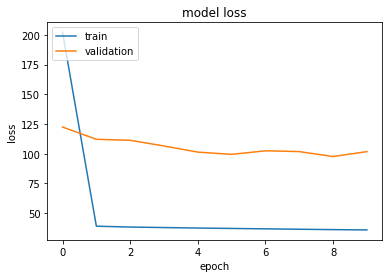

In [10]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [11]:
# training rrmse
rrmse_histories = []
rrmse_histories.append(history.history['rrmse'])
rrmse_history = [np.mean([x[i] for x in rrmse_histories]) for i in range(num_epochs)]

In [12]:
# validation rrmse
val_rrmse_histories = []
val_rrmse_histories.append(history.history['val_rrmse'])
val_rrmse_history = [np.mean([x[i] for x in val_rrmse_histories]) for i in range(num_epochs)]

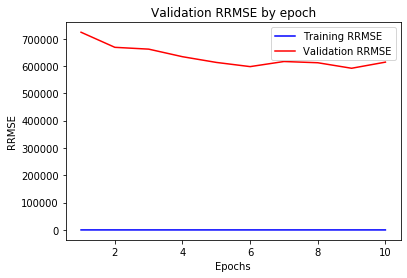

In [13]:
# plotting validation scores
import matplotlib.pyplot as plt
plt.plot(range(1,len(rrmse_history) + 1), rrmse_history, 'b', label='Training RRMSE')
plt.plot(range(1,len(val_rrmse_history) + 1), val_rrmse_history, 'r', label='Validation RRMSE')
plt.title('Validation RRMSE by epoch')
plt.xlabel('Epochs')
plt.ylabel('RRMSE')
plt.legend()
plt.show()

TUNING THE HYPERPARAMETERS IN THE MODEL

**Tuning Batch Size and Epochs**

In [0]:
def create_model():
  model = Sequential()
  model.add(Dense(50, input_dim=65, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(1, activation='linear'))
  model.summary()
  model.compile(loss='mae', optimizer = "adam", metrics=[rrmse, 'mse','mae'])
  return model

In [0]:
model = KerasRegressor(build_fn=create_model, verbose=1)
# define the grid search parameters
batch_size = [32, 64, 128]
epochs= [15,20,50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(xscale, y)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 50)                3300      
_________________________________________________________________
dense_23 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 21        
Total params: 4,341
Trainable params: 4,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
51000/51000 [==============================] - 2s 39us/step - loss: 192.7628 - rrmse: 1.4503 - mse: 109627.6953 - mae: 192.7626
Epoch 2/15
51000/51000 [==============================] - 2s 36us/step - loss: 44.9833 - rrmse: 0.4240 - mse: 4124.4399 - mae: 44.9833
Epoch 3/15
51000/51000 [==============================] - 2s 37us/step - loss: 43.2698 - rrmse: 0.4124 - mse

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -77.949805 using {'batch_size': 32, 'epochs': 15}
-77.949805 (22.601394) with: {'batch_size': 32, 'epochs': 15}
-86.163859 (30.006389) with: {'batch_size': 32, 'epochs': 20}
-93.496830 (31.048548) with: {'batch_size': 32, 'epochs': 50}
-87.617825 (26.147292) with: {'batch_size': 64, 'epochs': 15}
-79.264861 (24.307282) with: {'batch_size': 64, 'epochs': 20}
-90.680770 (33.616446) with: {'batch_size': 64, 'epochs': 50}
-83.438634 (20.279058) with: {'batch_size': 128, 'epochs': 15}
-80.998375 (18.986276) with: {'batch_size': 128, 'epochs': 20}
-86.905415 (32.366261) with: {'batch_size': 128, 'epochs': 50}


**Tuning the Training Optimization Algorithm**

In [14]:
def create_model(optimizer="adam"):
  model = Sequential()
  model.add(Dense(50, input_dim=65, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(1, activation='linear'))
  model.summary()
  model.compile(loss='mae', optimizer = optimizer, metrics=[rrmse, 'mse','mae'])
  return model


In [15]:
model = KerasRegressor(build_fn=create_model, epochs=15, batch_size=32, verbose=0)
# define the grid search parameters
optimizer = ['RMSprop', 'Autograd', 'Adam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(xscale, y)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                3300      
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
Total params: 4,341
Trainable params: 4,341
Non-trainable params: 0
_________________________________________________________________


In [16]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -79.850111 using {'optimizer': 'RMSprop'}
-79.850111 (23.262512) with: {'optimizer': 'RMSprop'}
nan (nan) with: {'optimizer': 'Autograd'}
-80.246104 (22.818104) with: {'optimizer': 'Adam'}


In [0]:
from keras.optimizers import RMSprop

**Tuning the Kernel Initializer**

In [17]:
def create_model(init_mode1='uniform', init_mode2='uniform'):
  model = Sequential()
  model.add(Dense(50, input_dim=65, kernel_initializer=init_mode1, activation='relu'))
  model.add(Dense(20, kernel_initializer=init_mode2, activation='relu'))
  model.add(Dense(1, activation='linear'))
  model.summary()
  model.compile(loss='mae', optimizer = 'RMSprop', metrics=[rrmse, 'mse','mae'])
  return model

In [18]:
model = KerasRegressor(build_fn=create_model, epochs=15, batch_size=32, verbose=1)
# define the grid search parameters
init_modes = ['uniform', 'lecun_uniform', 'normal']
param_grid = dict(init_mode1=init_modes, init_mode2=init_modes)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(xscale, y)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 50)                3300      
_________________________________________________________________
dense_8 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 4,341
Trainable params: 4,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
51000/51000 [==============================] - 3s 67us/step - loss: 146.3043 - rrmse: 1.1642 - mse: 72977.6406 - mae: 146.3044
Epoch 2/32
51000/51000 [==============================] - 3s 59us/step - loss: 46.3531 - rrmse: 0.4432 - mse: 4364.6025 - mae: 46.3531
Epoch 3/32
51000/51000 [==============================] - 3s 59us/step - loss: 45.9468 - rrmse: 0.4397 - mse:

In [19]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -79.708837 using {'init_mode1': 'normal', 'init_mode2': 'uniform'}
-82.449925 (22.277121) with: {'init_mode1': 'uniform', 'init_mode2': 'uniform'}
-87.463553 (24.068770) with: {'init_mode1': 'uniform', 'init_mode2': 'lecun_uniform'}
-82.424038 (27.998880) with: {'init_mode1': 'uniform', 'init_mode2': 'normal'}
-85.531353 (20.629139) with: {'init_mode1': 'lecun_uniform', 'init_mode2': 'uniform'}
-84.616120 (20.196038) with: {'init_mode1': 'lecun_uniform', 'init_mode2': 'lecun_uniform'}
-82.241294 (19.155503) with: {'init_mode1': 'lecun_uniform', 'init_mode2': 'normal'}
-79.708837 (21.175383) with: {'init_mode1': 'normal', 'init_mode2': 'uniform'}
-79.768184 (26.042497) with: {'init_mode1': 'normal', 'init_mode2': 'lecun_uniform'}
-89.492335 (29.537884) with: {'init_mode1': 'normal', 'init_mode2': 'normal'}


**Tuning Neuron Activation Function**

In [23]:
def create_model(activation1='relu',activation2='relu',activation3='relu'):
  model = Sequential()
  model.add(Dense(50, input_dim=65, kernel_initializer='normal', activation=activation1))
  model.add(Dense(20, kernel_initializer='uniform', activation=activation2))
  model.add(Dense(1, activation=activation3))
  model.summary()
  model.compile(loss='mae', optimizer = 'RMSprop', metrics=[rrmse, 'mse','mae'])
  return model

In [24]:
model = KerasRegressor(build_fn=create_model, epochs=15, batch_size=32, verbose=1)
# define the grid search parameters
activation = ['relu', 'tanh', 'linear']
param_grid = dict(activation1=activation,activation2=activation,activation3=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(xscale, y)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 50)                3300      
_________________________________________________________________
dense_11 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 21        
Total params: 4,341
Trainable params: 4,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
51000/51000 [==============================] - 2s 43us/step - loss: 225.0848 - rrmse: 1.6659 - mse: 128924.3828 - mae: 225.0850
Epoch 2/15
51000/51000 [==============================] - 2s 37us/step - loss: 46.4804 - rrmse: 0.4378 - mse: 4372.3101 - mae: 46.4804
Epoch 3/15
51000/51000 [==============================] - 2s 35us/step - loss: 45.7347 - rrmse: 0.4315 - mse

In [25]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -79.326309 using {'activation1': 'relu', 'activation2': 'linear', 'activation3': 'relu'}
-83.955538 (19.843343) with: {'activation1': 'relu', 'activation2': 'relu', 'activation3': 'relu'}
-766.648502 (136.384508) with: {'activation1': 'relu', 'activation2': 'relu', 'activation3': 'tanh'}
-80.542652 (23.422634) with: {'activation1': 'relu', 'activation2': 'relu', 'activation3': 'linear'}
-426.831412 (136.566496) with: {'activation1': 'relu', 'activation2': 'tanh', 'activation3': 'relu'}
-766.648502 (136.384508) with: {'activation1': 'relu', 'activation2': 'tanh', 'activation3': 'tanh'}
-427.069940 (136.456068) with: {'activation1': 'relu', 'activation2': 'tanh', 'activation3': 'linear'}
-79.326309 (22.468392) with: {'activation1': 'relu', 'activation2': 'linear', 'activation3': 'relu'}
-766.648502 (136.384508) with: {'activation1': 'relu', 'activation2': 'linear', 'activation3': 'tanh'}
-82.865247 (20.172590) with: {'activation1': 'relu', 'activation2': 'linear', 'activation3': 'l

**Tuning Dropout Regularization**

In [29]:
def create_model(dropout_rate=0.0):
  model = Sequential()
  model.add(Dense(50, input_dim=65, kernel_initializer='normal', activation='relu'))
  model.add(Dense(20, kernel_initializer='uniform' ,activation='linear'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1, activation='relu'))
  model.summary()
  model.compile(loss='mae', optimizer = 'RMSprop', metrics=[rrmse, 'mse','mae'])
  return model

In [30]:
model = KerasRegressor(build_fn=create_model, epochs=15, batch_size=32, verbose=1)
# define the grid search parameters
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(xscale, y)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 50)                3300      
_________________________________________________________________
dense_17 (Dense)             (None, 20)                1020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 21        
Total params: 4,341
Trainable params: 4,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
51000/51000 [==============================] - 2s 39us/step - loss: 226.5854 - rrmse: 1.6781 - mse: 130504.3516 - mae: 226.5852
Epoch 2/15
51000/51000 [==============================] - 2s 32us/step - loss: 46.4945 - rrmse: 0.4374 - mse: 4

In [31]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -80.480936 using {'dropout_rate': 0.0}
-80.480936 (18.320726) with: {'dropout_rate': 0.0}
-83.928671 (21.294574) with: {'dropout_rate': 0.1}
-86.812415 (26.397145) with: {'dropout_rate': 0.2}
-93.441405 (31.593513) with: {'dropout_rate': 0.3}
-94.477625 (42.009005) with: {'dropout_rate': 0.4}
-94.637713 (36.309507) with: {'dropout_rate': 0.5}
-99.000916 (44.238358) with: {'dropout_rate': 0.6}
-110.651466 (57.943263) with: {'dropout_rate': 0.7}
-139.983021 (74.856672) with: {'dropout_rate': 0.8}
-231.662012 (98.954121) with: {'dropout_rate': 0.9}


**Tuning Number of Neurons in the Hidden Layer**

In [32]:
def create_model(neuron1=10, neuron2= 10):
  model = Sequential()
  model.add(Dense(neuron1, input_dim=65, kernel_initializer='normal', activation='relu'))
  model.add(Dense(neuron2, kernel_initializer='uniform' ,activation='linear'))
  model.add(Dropout(0.0))
  model.add(Dense(1, activation='relu'))
  model.summary()
  model.compile(loss='mae', optimizer = 'RMSprop', metrics=[rrmse, 'mse','mae'])
  return model

In [33]:
model = KerasRegressor(build_fn=create_model, epochs=15, batch_size=32, verbose=1)
# define the grid search parameters
neurons = [10, 20, 32, 50, 64]
param_grid = dict(neuron1=neurons, neuron2=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(xscale, y)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 32)                2112      
_________________________________________________________________
dense_20 (Dense)             (None, 50)                1650      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 51        
Total params: 3,813
Trainable params: 3,813
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
51000/51000 [==============================] - 2s 42us/step - loss: 201.0778 - rrmse: 1.5028 - mse: 112102.3672 - mae: 201.0779
Epoch 2/15
51000/51000 [==============================] - 2s 36us/step - loss: 46.3427 - rrmse: 0.4364 - mse: 4

In [34]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -77.561942 using {'neuron1': 32, 'neuron2': 50}
-80.575074 (17.405341) with: {'neuron1': 10, 'neuron2': 10}
-82.044027 (19.354526) with: {'neuron1': 10, 'neuron2': 20}
-83.910710 (18.894650) with: {'neuron1': 10, 'neuron2': 32}
-83.330257 (19.857901) with: {'neuron1': 10, 'neuron2': 50}
-84.390241 (21.183205) with: {'neuron1': 10, 'neuron2': 64}
-82.621102 (19.303914) with: {'neuron1': 20, 'neuron2': 10}
-84.978463 (21.773403) with: {'neuron1': 20, 'neuron2': 20}
-81.359494 (17.850242) with: {'neuron1': 20, 'neuron2': 32}
-83.059867 (19.478843) with: {'neuron1': 20, 'neuron2': 50}
-79.807351 (17.493923) with: {'neuron1': 20, 'neuron2': 64}
-83.480678 (20.593010) with: {'neuron1': 32, 'neuron2': 10}
-82.700835 (22.742201) with: {'neuron1': 32, 'neuron2': 20}
-84.339782 (22.138093) with: {'neuron1': 32, 'neuron2': 32}
-77.561942 (17.208225) with: {'neuron1': 32, 'neuron2': 50}
-81.349216 (20.663819) with: {'neuron1': 32, 'neuron2': 64}
-80.972358 (20.521987) with: {'neuron1': 50, '